# **Loan Default Prediction**

## **Problem Definition**

### **The Context:**

A major proportion of retail bank profit comes from interests in the form of home loans. These loans
are borrowed by regular income/high-earning customers. Banks are most fearful of defaulters, as
bad loans (NPA) usually eat up a major chunk of their profits. Therefore, it is important for banks to
be judicious while approving loans for their customer base.
The approval process for the loans is multifaceted. Through this process, the bank tries to check the
creditworthiness of the applicant on the basis of a manual study of various aspects of the
application. The entire process is not only effort-intensive but also prone to wrong
judgment/approval owing to human error and biases.
There have been attempts by many banks to automate this process by using heuristics. But with the
advent of data science and machine learning, the focus has shifted to building machines that can
learn this approval process and make it free of biases and more efficient. At the same time, one
important thing to keep in mind is to make sure that the machine does not learn the biases that
previously crept in because of the human approval process
### **The objective:**

Build a classification model to predict clients who are likely to default on their loan and give
recommendations to the bank on the important features to consider while approving a loan.
### **The key questions:**

- Which clients are more likely to default on their loan?
- What are the essential createria to consider during the load approval process?

### **The problem formulation**:

A bank's consumer credit department aims to simplify the decision-making process for home equity
lines of credit to be accepted. To do this, they will adopt the Equal Credit Opportunity Act's
guidelines to establish an empirically derived and statistically sound model for credit scoring. The
model will be based on the data obtained via the existing loan underwriting process from recent
applicants who have been given credit. The model will be built from predictive modeling techniques,
but the model created must be interpretable enough to provide a justification for any adverse
behavior (rejections).

## **Data Description:**
The Home Equity dataset (HMEQ) contains baseline and loan performance information for 5,960 recent home equity loans. The target (BAD) is a binary variable that indicates whether an applicant has ultimately defaulted or has been severely delinquent. This adverse outcome occurred in 1,189 cases (20 percent). 12 input variables were registered for each applicant.


* **BAD:** 1 = Client defaulted on loan, 0 = loan repaid

* **LOAN:** Amount of loan approved.

* **MORTDUE:** Amount due on the existing mortgage.

* **VALUE:** Current value of the property. 

* **REASON:** Reason for the loan request. (HomeImp = home improvement, DebtCon= debt consolidation which means taking out a new loan to pay off other liabilities and consumer debts) 

* **JOB:** The type of job that loan applicant has such as manager, self, etc.

* **YOJ:** Years at present job.

* **DEROG:** Number of major derogatory reports (which indicates a serious delinquency or late payments). 

* **DELINQ:** Number of delinquent credit lines (a line of credit becomes delinquent when a borrower does not make the minimum required payments 30 to 60 days past the day on which the payments were due). 

* **CLAGE:** Age of the oldest credit line in months. 

* **NINQ:** Number of recent credit inquiries. 

* **CLNO:** Number of existing credit lines.

* **DEBTINC:** Debt-to-income ratio (all your monthly debt payments divided by your gross monthly income. This number is one way lenders measure your ability to manage the monthly payments to repay the money you plan to borrow.

### Additional Installation

In [ ]:
! pip install xgboost
! pip install imblearn

## **Import the Necessary Libraries and Data**

In [2264]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


from sklearn.impute import SimpleImputer,MissingIndicator


# Essential liberaries
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Classification algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# Performance metrices
from sklearn.metrics import confusion_matrix, classification_report, recall_score,precision_score,accuracy_score, f1_score
from sklearn import metrics

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV



## **Data Overview**

- Reading the dataset
- Understanding the shape of the dataset
- Checking the data types
- Checking for missing values
- Checking for duplicated values

In [2265]:
data = pd.read_csv('hmeq.csv')
data.columns = list(map(str.lower,data.columns))
data.head()

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [2266]:
data.shape

(5960, 13)

In [2267]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bad      5960 non-null   int64  
 1   loan     5960 non-null   int64  
 2   mortdue  5442 non-null   float64
 3   value    5848 non-null   float64
 4   reason   5708 non-null   object 
 5   job      5681 non-null   object 
 6   yoj      5445 non-null   float64
 7   derog    5252 non-null   float64
 8   delinq   5380 non-null   float64
 9   clage    5652 non-null   float64
 10  ninq     5450 non-null   float64
 11  clno     5738 non-null   float64
 12  debtinc  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


**Save the names of numeric and the categorical columns for further use**

In [2268]:
num_feats = list(data.select_dtypes('number').columns)
# convert object type to category for best memory usage
data[['job','reason']] = data[['job','reason']].astype('category')

cat_feats = ['job','reason']

# exclude the target variable
if 'bad' in num_feats:
    num_feats.remove('bad')

In [2269]:
data.nunique()


bad           2
loan        540
mortdue    5053
value      5381
reason        2
job           6
yoj          99
derog        11
delinq       14
clage      5314
ninq         16
clno         62
debtinc    4693
dtype: int64

In [2270]:
# check duplicates
data.duplicated().sum()

0

In [2271]:
total_values = data.shape[0]*data.shape[1]
#ratio of missing values
print('Ratio of missing values',data.isnull().values.sum()/total_values *100)
# ratio of missing values in each column

print('Ratio of missing values per column:\n')
print((data.isnull().sum() *100 / len(data)).sort_values(ascending=False))




Ratio of missing values 6.803045947341249
Ratio of missing values per column:

debtinc    21.258389
derog      11.879195
delinq      9.731544
mortdue     8.691275
yoj         8.640940
ninq        8.557047
clage       5.167785
job         4.681208
reason      4.228188
clno        3.724832
value       1.879195
bad         0.000000
loan        0.000000
dtype: float64


Text(0.5, 1, 'Ratio of missing values in the dataset')

<Figure size 720x432 with 0 Axes>

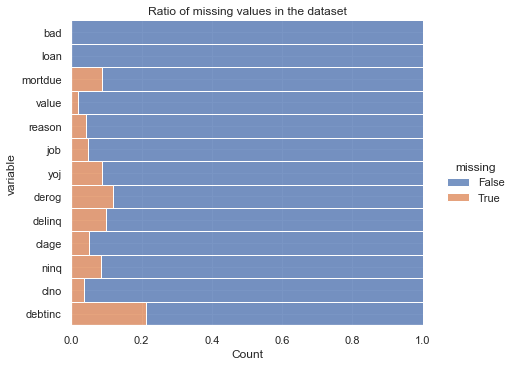

In [2272]:
plt.figure(figsize=(10,6))
sns.displot(
    data=data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.title('Ratio of missing values in the dataset')


**Observation**

- There are 5960 observations and 13 features.
- There are 11 numeric features and 2 are of type object.
- Variable **job** has a nominal type and variable **reason** has a categorical binary type.
- The response variable **bad** is numerical binary.
- No duplicates are found in the data.
- There are missing values in multiple features, and the ratio of missing values is around 7% from the entire data.
- Features **debtinc** and **derog** have the majority of the missing values.
- As the ratio of the missing values is very small, imputation techniques can be used to handle the missing values.




## Summary Statistics

In [2273]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
bad,5960.0,0.199497,0.399656,0.000000,0.000000,0.000000,0.000000,1.000000
loan,5960.0,18607.969799,11207.480417,1100.000000,11100.000000,16300.000000,23300.000000,89900.000000
mortdue,5442.0,73760.817200,44457.609458,2063.000000,46276.000000,65019.000000,91488.000000,399550.000000
value,5848.0,101776.048741,57385.775334,8000.000000,66075.500000,89235.500000,119824.250000,855909.000000
yoj,5445.0,8.922268,7.573982,0.000000,3.000000,7.000000,13.000000,41.000000
derog,5252.0,0.254570,0.846047,0.000000,0.000000,0.000000,0.000000,10.000000
delinq,5380.0,0.449442,1.127266,0.000000,0.000000,0.000000,0.000000,15.000000
clage,5652.0,179.766275,85.810092,0.000000,115.116702,173.466667,231.562278,1168.233561
ninq,5450.0,1.186055,1.728675,0.000000,0.000000,1.000000,2.000000,17.000000
clno,5738.0,21.296096,10.138933,0.000000,15.000000,20.000000,26.000000,71.000000


In [2274]:
data.describe(include='category').T

,count,unique,top,freq
reason,5708,2,DebtCon,3928
job,5681,6,Other,2388


**Observations from Summary Statistics**

- The average loan amount is around 18,608, with at least 50\% of customers requesting loans of 16,300 or higher.
- The variables loan, mortdue, and value exhibit a wide range, indicating diversity in customers' loan applications.
- There is positive skewness in the data.
- The means of features (loan, mortdue, value) are higher than the medians, indicating right skewness in the data.
- On average, customers have 9 years of job experience, with at least 50% of them spending 7 years or more in their jobs.
- Customers receive derogatory reports (derog) ranging from 0 to 10, with a right-skewed distribution and at least 50% of customers receiving at least 0 reports.
- Similarly, the number of delinquent credit lines is skewed to the right, with data ranging from 0 to 15.
- There are customers with credit ages ranging from 0 to 1168 months.
- At least 50% of applicants have 1 recent credit, with the range of ninq varying from 0 to 17.
- At least 50% of applicants have 21 existing credits, with the variable clno ranging from 0 to 71.
- The range in the Debt-to-income variable debtinc is very high, potentially due to a large number of outliers, with an approximate value of 35% for at least 50% of applicants.
- The features reason and job also have missing values.
- There are 6 unique job titles, with the most frequent title being other.
- The reason variable has two unique values, with most applicants requesting loans for debt consolidation.




## **Exploratory Data Analysis (EDA) and Visualization**

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Leading Questions**:
1. What is the range of values for the loan amount variable "LOAN"?
2. How does the distribution of years at present job "YOJ" vary across the dataset?
3. How many unique categories are there in the REASON variable?
4. What is the most common category in the JOB variable?
5. Is there a relationship between the REASON variable and the proportion of applicants who defaulted on their loan?
6. Do applicants who default have a significantly different loan amount compared to those who repay their loan?
7. Is there a correlation between the value of the property and the loan default rate?
8. Do applicants who default have a significantly different mortgage amount compared to those who repay their loan?

### **Univariate Analysis**


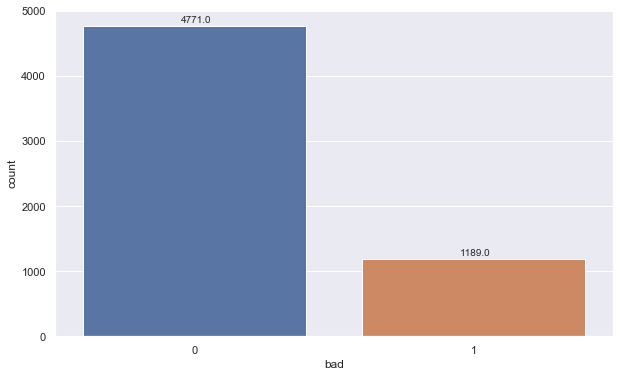

In [2275]:
# count the number of defaulted loans

plt.figure(figsize=(10,6))

ax = sns.countplot(data=data,x='bad')

for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+50))

**Observations**
- The number of paid customers is significantly more than the defaulted ones
- The defaulted customers represent 20% of the total applications 
- This data is unbalanced

**Distribution of the numerical features**

In [2276]:
def hist_boxplot(df,cols):
    for col in cols:
        print(col)

        print('Skew :',round(df[col].skew(), 2))

        plt.figure(figsize = (15, 4))

        plt.subplot(1, 3, 1)

        df[col].hist(bins = 10, grid = False)

        plt.ylabel('count')

        plt.subplot(1, 3, 2)

        sns.boxplot(x = df[col])
        
        plt.subplot(1,3,3)
        stats.probplot(df[col],plot=plt)

        plt.show()

loan
Skew : 2.02


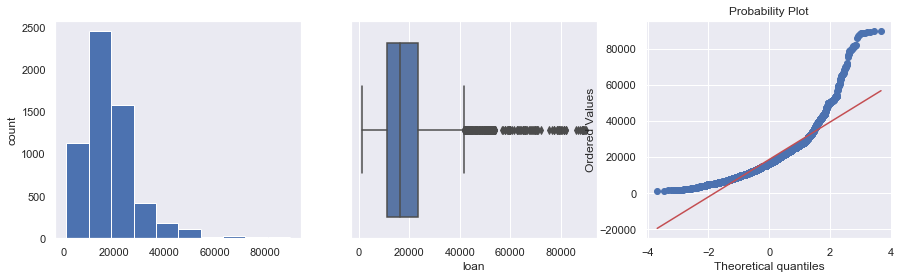

mortdue
Skew : 1.81


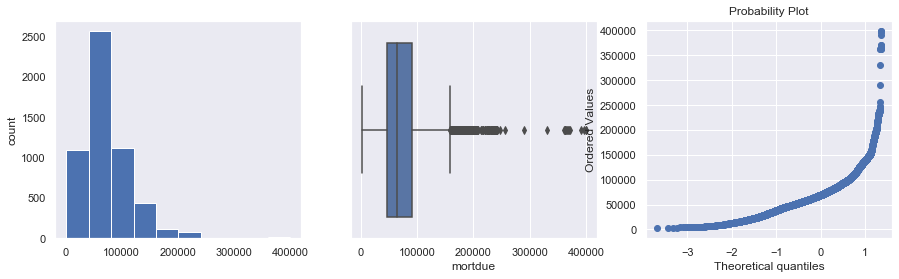

value
Skew : 3.05


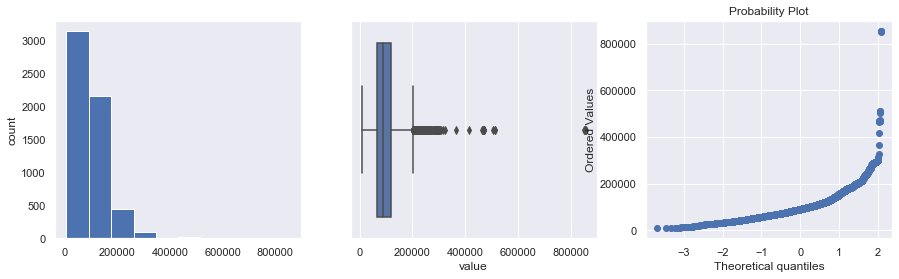

yoj
Skew : 0.99


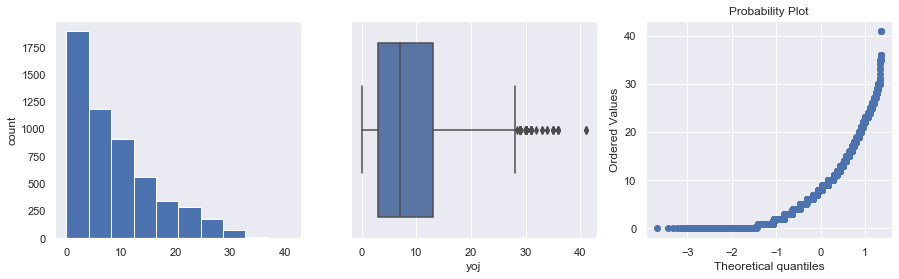

derog
Skew : 5.32


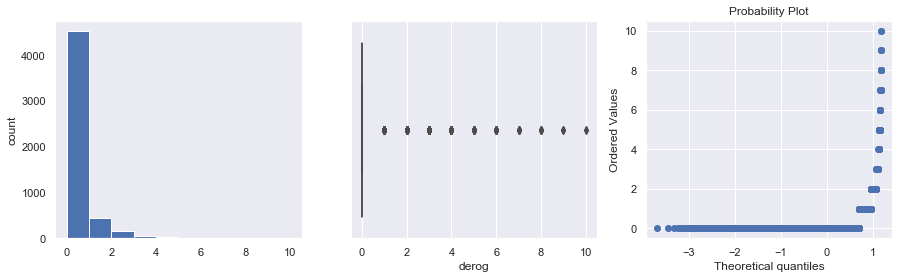

delinq
Skew : 4.02


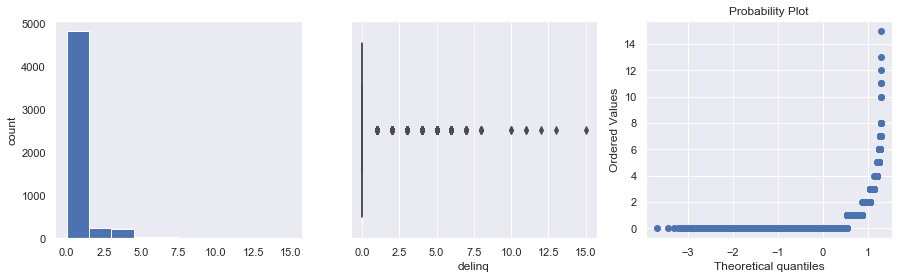

clage
Skew : 1.34


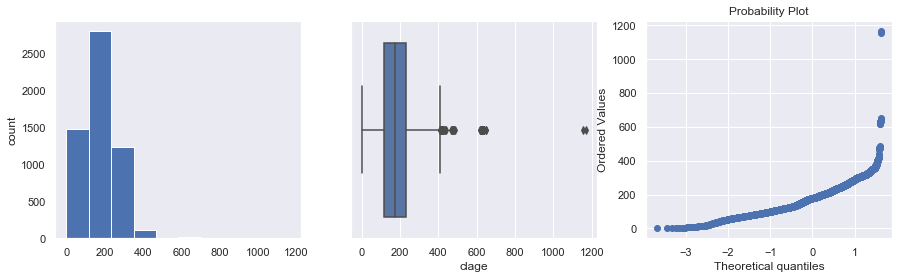

ninq
Skew : 2.62


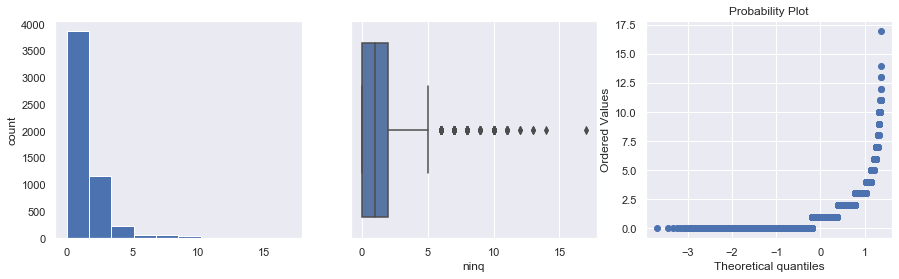

clno
Skew : 0.78


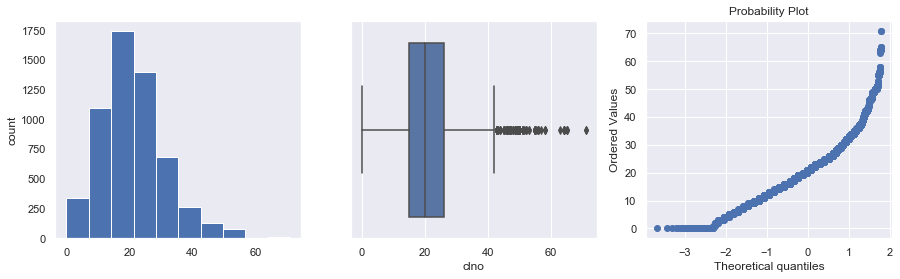

debtinc
Skew : 2.85


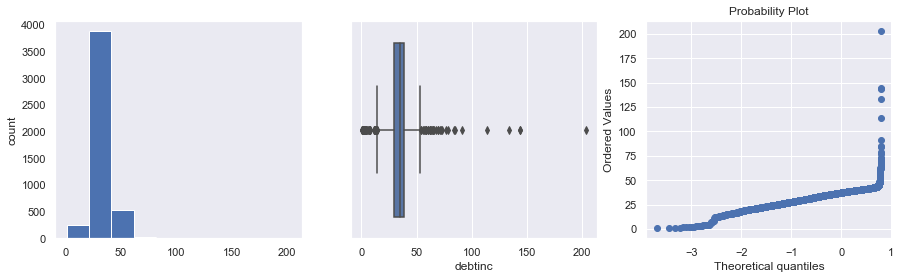

In [2277]:
hist_boxplot(data,num_feats)

**The boxplot of *derog* and *delinq* show a very dense distriution, we can count the values of these variables**

In [2278]:
# find the ratio of values in *derog* and *delinq* variables

for c in ['derog','delinq']:
    print(f'Count values of variable: {c}')
    print(data[c].value_counts()/len(data))


Count values of variable: derog
0.0     0.759564
1.0     0.072987
2.0     0.026846
3.0     0.009732
4.0     0.003859
5.0     0.002517
6.0     0.002517
7.0     0.001342
8.0     0.001007
9.0     0.000503
10.0    0.000336
Name: derog, dtype: float64
Count values of variable: delinq
0.0     0.701174
1.0     0.109732
2.0     0.041946
3.0     0.021644
4.0     0.013087
5.0     0.006376
6.0     0.004530
7.0     0.002181
8.0     0.000839
10.0    0.000336
11.0    0.000336
15.0    0.000168
12.0    0.000168
13.0    0.000168
Name: delinq, dtype: float64


**Distribution of the Categorical features. We start by ploting the categorical variables using barplots**

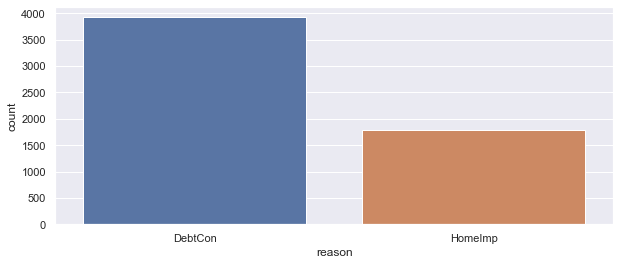

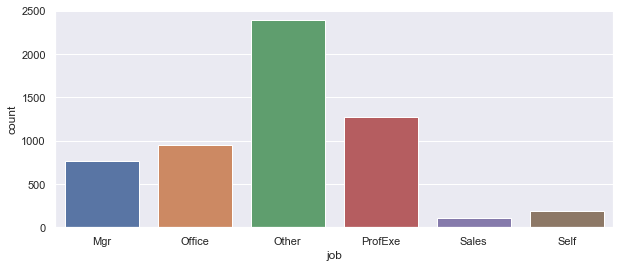

In [2279]:
for c in list(data.select_dtypes('category').columns):
    plt.figure(figsize=(10,4))
    sns.countplot(data=data,x=c)
    

**Observations**

- The data is right skewed and contains outliers
- Most of the predicted variables contain outliers larger than 75% percentile. The variable **debtinc** has also outliers less than 25% percentile.
- The data has a positive skewness, and features **derog** and **delinq** have the highest skewed values
- Most of the values in **derog** and **delinq** are close to 0. We can see that around **78%** customers do not get delinquency reports, and **70%** without delinquent credit lines.
- Variable **debtinc** has outliers in both left and right sides and most of the values are within 25% to 50\%.
- The most frequent values in **job** and **reason** variables are "Other" and "DebtCon"


### **Bivariate Analysis**

In [2280]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    
    predictor: independent variable
    
    target: target variable
    """
    count = data[predictor].nunique()
    
    sorter = data[target].value_counts().index[-1]
    
    tab1 = pd.crosstab(data[predictor], data[target], margins = True).sort_values(
        by = sorter, ascending = False
    )
    
    print(tab1)
    
    print("-" * 120)
    
    tab = pd.crosstab(data[predictor], data[target], normalize = "index").sort_values(
        by = sorter, ascending = False
    )
    
    tab.plot(kind = "bar", stacked = True, figsize = (count + 1, 5))
    
    plt.legend(
        loc = "lower left",
        frameon = False,
    )
    
    plt.legend(loc = "upper left", bbox_to_anchor = (1, 1))
    
    plt.show()

**The next barplot shows Which job customers stay longer in their jobs**

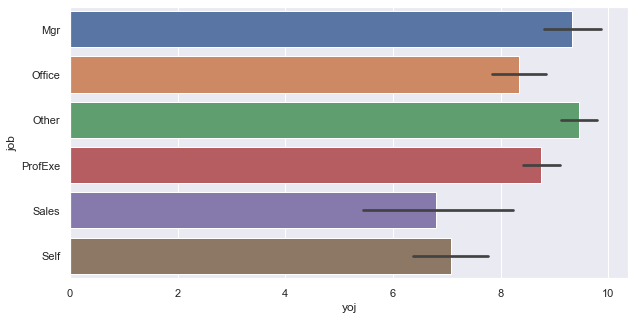

In [2281]:
plt.figure(figsize=(10,5))

sns.barplot(y = 'job', x = 'yoj', data = data)

plt.show()

**Observations**
- Customers who work as *managers* and *Other* stay longer in their jobs

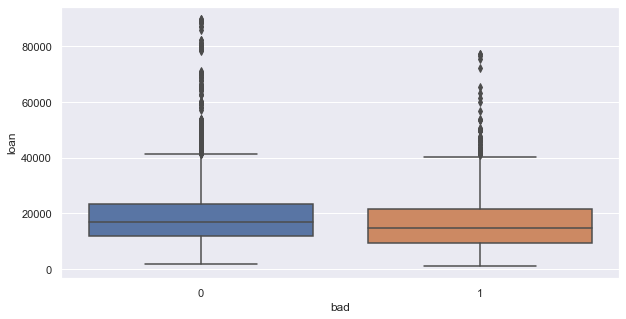

In [2282]:
# The distribution of loan and default likelihood
plt.figure(figsize = (10, 5))

sns.boxplot(data = data, x=data['bad'],y=data['loan']) 

plt.show()

In [2283]:
data[data['bad']==1]['loan'].mean()


16922.11942809083

**Observations**
- Median of Loans of customers who do not default is higher than the defaulted ones.
- Outliers exist in loan of customers regardless of they default or not.

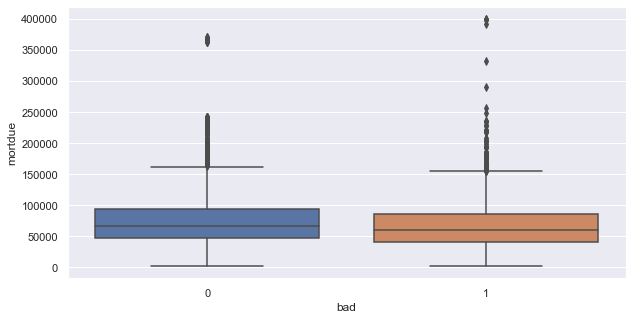

In [2284]:
plt.figure(figsize=(10,5))
sns.boxplot(data=data,x=data['bad'],y=data['mortdue'])
plt.show()

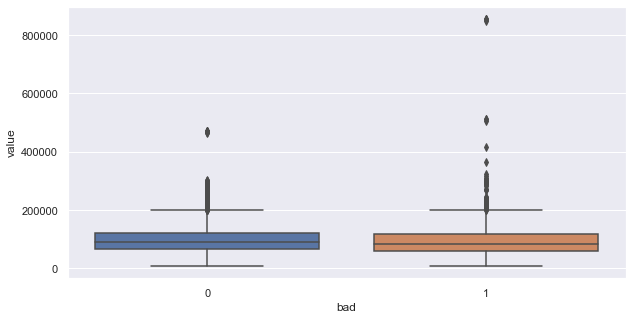

In [2285]:
plt.figure(figsize=(10,5))
sns.boxplot(data=data,x=data['bad'],y=data['value'])
plt.show()

**Observations**
- The distribution of both **mortdue** and **value** in non-defaulted customers are slightely higher than the defaulted ones
- The distribution of both variables on defaulted customers have some extreme values, which can be outliers

bad         0     1   All
reason                   
All      4567  1141  5708
DebtCon  3183   745  3928
HomeImp  1384   396  1780
------------------------------------------------------------------------------------------------------------------------


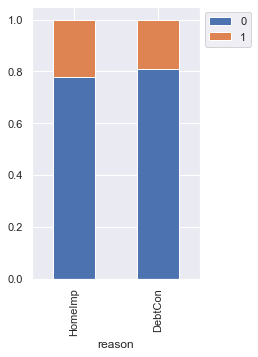

In [2286]:
stacked_barplot(data,'reason','bad')

bad         0     1   All
job                      
All      4515  1166  5681
Other    1834   554  2388
ProfExe  1064   212  1276
Mgr       588   179   767
Office    823   125   948
Self      135    58   193
Sales      71    38   109
------------------------------------------------------------------------------------------------------------------------


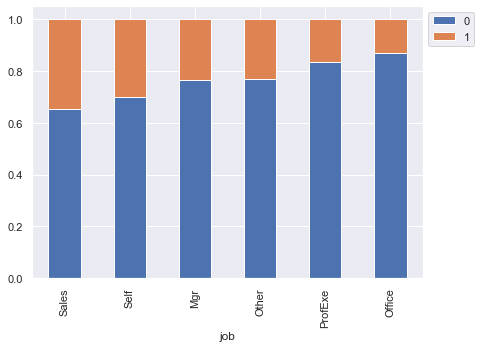

In [2287]:
stacked_barplot(data,'job','bad')

**Observations**
- Requested loans with **reason** as *HomeImp* or home improvement have more chance to be defaulted
- Customers who work in *sales* and *self employed* are more likely to default
- Customers who work in *office* and *prifExe* have a lower chance to default. *Managers* and *other* employers have close chance to default.

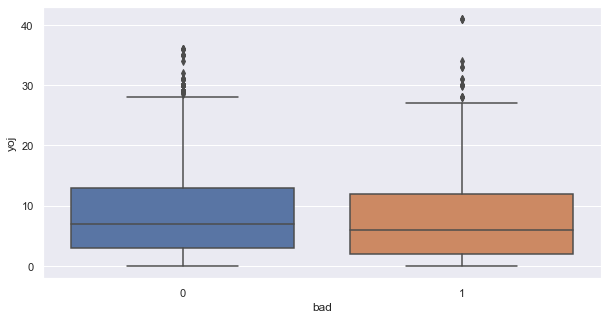

In [2288]:
plt.figure(figsize=(10,5))
sns.boxplot(data=data,x=data['bad'],y=data['yoj'])
plt.show()

**Observations**
- Customers who default have shorter years of of experience in compare non-defaulters
- There are extereme values in **yoj** in both boxplots, they may be condsidered as outliers

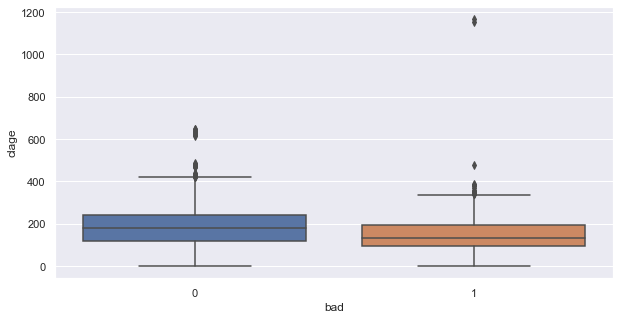

In [2402]:
plt.figure(figsize=(10,5))
sns.boxplot(data=data,x=data['bad'],y=data['clage'])
plt.show()

**Observations**

- Customers who have longer credit histories, with older credit lines, are more likely to repay their loans.

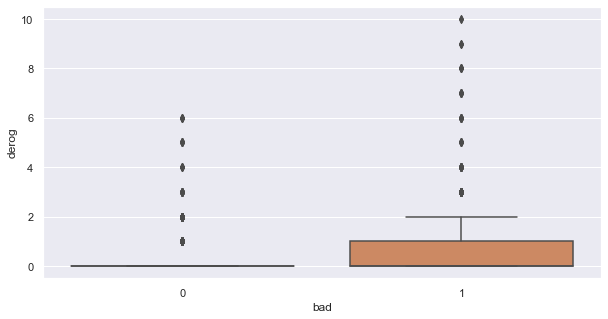

In [2289]:
plt.figure(figsize=(10,5))
sns.boxplot(data=data,x=data['bad'],y=data['derog'])
plt.show()

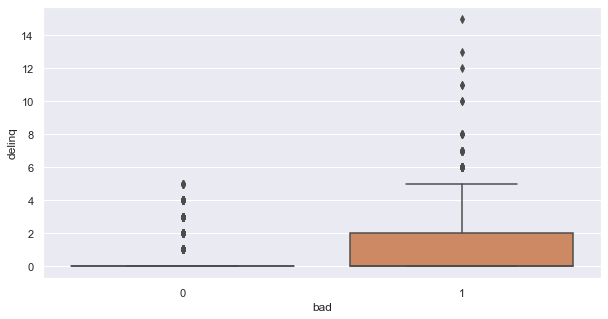

In [2290]:
plt.figure(figsize=(10,5))
sns.boxplot(data=data,x=data['bad'],y=data['delinq'])
plt.show()

**Observations**
- As we can see that defaulters have higher number deterogatory reports and deliduent credit lines.
- the majority of **derog** and **delinq** values are close to 0 in the case of non-defaulters and are higher with defaulters. This is obveious as these customers are more likely to repay their loans on time.


Giving the current distributions of columns **derog** and **delinq**, they may not be informative for the model.
Lets create new binary columns to represent them, such that values equal to 0 willremain 0 and values larger than 0 will be 1. 


In [2291]:
data['derog_b'] = (data['derog']>=1)*1
data['delinq_b'] = (data['delinq']>=1)*1

num_feats += ['derog_b','delinq_b'] 

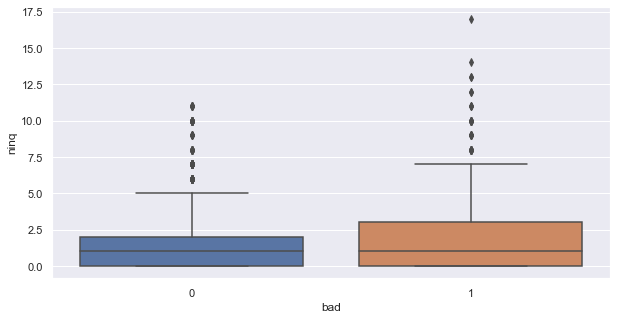

In [2292]:
plt.figure(figsize=(10,5))
sns.boxplot(data=data,x=data['bad'],y=data['ninq'])
plt.show()

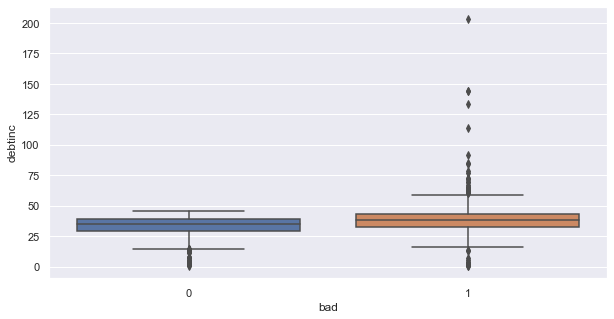

In [2293]:
plt.figure(figsize=(10,5))
sns.boxplot(data=data,x=data['bad'],y=data['debtinc'])
plt.show()

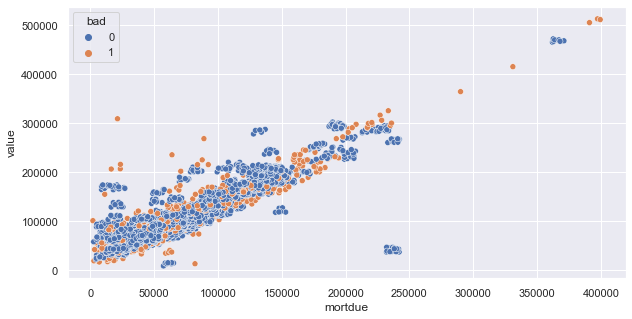

In [2294]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=data["mortdue"],y=data['value'], hue=data['bad'])
plt.show()

**Correlation between mortdue and loan**

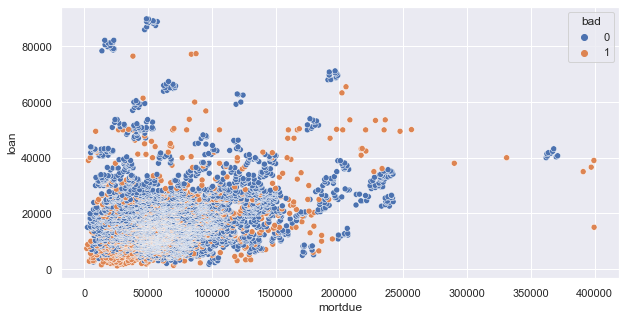

In [2295]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=data["mortdue"],y=data['loan'], hue=data['bad'])
plt.show()

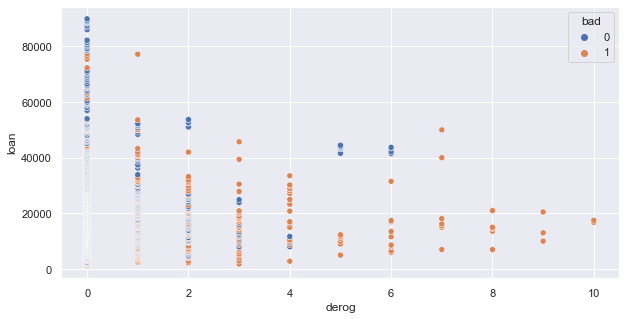

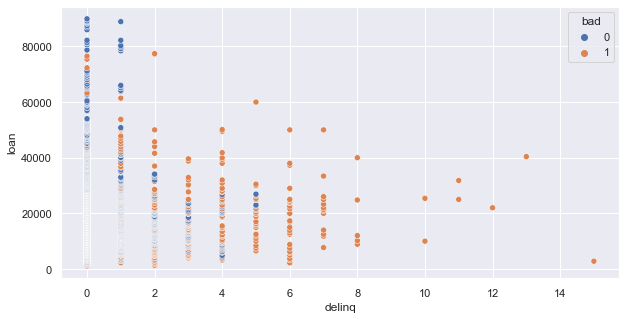

In [2296]:
for col in ['derog','delinq']:
    plt.figure(figsize=(10,5))
    sns.scatterplot(x=data[col],y=data['loan'], hue=data['bad'])
    plt.show()

**Observations**
- There is a positive correlation between **mortdue** and **value** 
- Customers who recive high derogatory reports or high number of delinquent credit lines are more likely to default

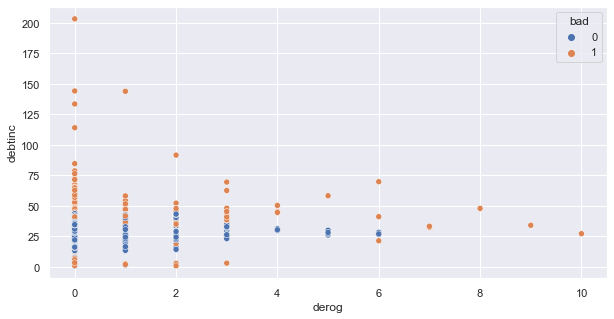

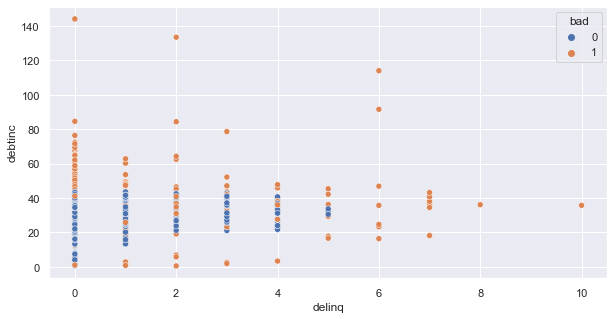

In [2297]:
for col in ['derog','delinq']:
    plt.figure(figsize=(10,5))
    sns.scatterplot(x=data[col],y=data['debtinc'], hue=data['bad'])
    plt.show()

### **Multivariate Analysis**

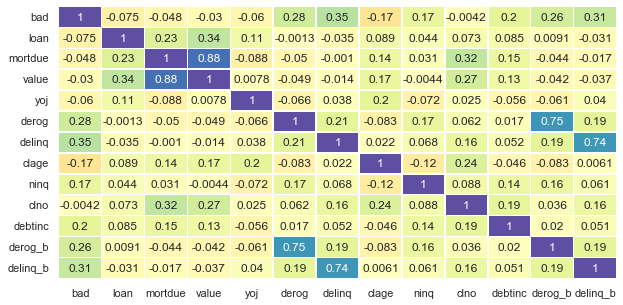

In [2298]:
# Correlation matrix

sns.set(rc={"figure.figsize": (10, 5)})
sns.heatmap(
    data.corr(), annot=True, linewidths=0.5, center=0, cbar=False, cmap="Spectral"
)
plt.show()

**observations**
- There is a strong positive correlation between customers' property values and outstanding mortgages. We can still keep them without affecting the classification algorithm. 
- High number of derogatory reports affects negatively the amount of loan.
- Customers with many years in their jobs have a lower number of deterogatory reports.
- Customers who have old credit lines have low debt-to-income.



## Treating Outliers

Outliers are data points that exhibit substantial deviation from the overall pattern of observations, appearing as anomalies. Failing to account for or acknowledge outliers in machine learning algorithms can lead to misleading results.
One potential approach for handling outliers is to set a cap on values that exceed the third quartile (Q3), limiting them to the value of Q3. Similarly, values that fall below the first quartile (Q1) can be capped at the value of Q1. This way, the extreme values are still taken into consideration during analysis, but their influence is mitigated.

In [2409]:
def handle_outliers_column(df,col):
    '''
    Treat outliers
    Args:
    df: pf.DataFrame
    col: String
    
    '''
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1 -1.5*IQR
    upper_bound = Q3+1.5*IQR
    
   
    outliers = df.loc[(df[col] < lower_bound)|(df[col] > upper_bound)][col]
    df[col] = np.where(df[col] < lower_bound,lower_bound,np.where(df[col]>upper_bound,upper_bound,df[col]))


def treat_all_outliers(df, cols):
    for col in cols:
        handle_outliers_column(df, col)
    return df




## Treating Missing Values, Scaling, and Encoding

 Pipeline and ColumnTranformer are used to automate multiple steps. For example numerical features undergo imputation of missing values and scaling.
On the other hand categorical features undergo imputation and encoding. Two imputation methods in sciket-learn are used, SimpleImputer and IterativeImputer.
SimpleImputer is a straight forward technique, all missing values are replaced with a constant value. In this case, median in numerical features and mode in the categorical features.
The IterativeImputer is more advanced technique that is based on predicting the missiing values using any estimator, and an be applied iteratively. For scaling the numerical features, RobustScaler is used, which can mitigate the right skewness in the data.

In [2329]:
def data_transform(df):

    '''
     Preprocess the data using pipelines and columndtransformer
    Args:
    df: pd.DataFrame
    
    Return:
    preprocesser: ColumnTransformer
    
    '''
    
    num_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='median',add_indicator=False)),
        ('scale',RobustScaler())
        ])
    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent',add_indicator=False)),
        ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False,drop='first'))
        ])
   
    preprocesser = ColumnTransformer(transformers=[
        ('mi',MissingIndicator(),df.columns),
        ('num_pipeline',num_pipeline,num_feats),
        ('cat_pipeline',cat_pipeline,cat_feats)
        ],
        remainder='drop',
        n_jobs=-1)
    return preprocesser



## **Important Insights from EDA**


- The raw data includes 5960 observations and 13 columns (11 numeric, 2 categorical).
- The response feature is 'bad', it is numerical, its value is either 0 or 1.
- There is right skewness and missing values in most of the columns.
- Defaulted customers represent 20% of overall observations.
- There are 6 differnt job categories and the most frequent job is specified as "Other" in the dataset.
- Home improvement is common among defaulters.
- The means of loan, mortdue, and value are lower for defaulters compared to non-defaulters.
- Non-defaulters have a slightly higher mortdue than defaulters.
- High amount due on the existing mortgage is posively correlated with current value of the property.
- Defaulted customers have higher number of deterogatory reports and delinquent credit lines.
- The debt to income is high in the case of defaulters, which indicates their inability to repay.
- The amount of loan decreases with the increase in delinq.
- There is a positive correlation between the number of existing credits and amount due on the existing mortgage.



## **Model Building - Approach**
- Data preparation
- Partition the data into train and test set
- Build the model
- Fit on the train data
- Tune the model
- Test the model on test set

### Data preperation

Data preperation workflow

- Split the data into train and test
- Treat the outliers 
- Treat the categorical variables
- Handle missing data


**Seperate the predictors and the target variable.**

In [2330]:
X = data.drop('bad',axis=1)
Y = data.bad

**As a good practice, the data split comes first to avoid data leak.**

Split the data into train and test using 80-20 rule

In [2331]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 10)

Handle outliers in the predictors of train and test.

In [2332]:
X_train_processed= treat_all_outliers(X_train,num_feats)
X_test_processed = treat_all_outliers(X_test,num_feats)



Then transform the data.

In [2333]:
processor = data_transform(X_train_processed)
processor.fit_transform(X_train_processed)
mi_features = [f+'_missing' for f in data.columns[data.isnull().any()]]
#mi_features = col_trans.named_transformers_['mi'].features_
enc_cat_features = processor.named_transformers_['cat_pipeline']['one-hot'].get_feature_names()

labels = np.concatenate([mi_features,num_feats, enc_cat_features])
X_train_transformed = pd.DataFrame(processor.transform(X_train_processed),columns=labels)
X_test_transformed = pd.DataFrame(processor.transform(X_test_processed),columns=labels)


### **Model evaluation criterion**
There are two types of errors that might occure in the prediction:
- Predicting a customer as a defaulter but he is not a defaulter (false positive)
- Predicting a customer as a non-defaulter but he is a defaulter (false negative)

In the current problem, the risk of false negatives in predictions is particularly concerning as it could result in financial losses for banks. On the other hand, the cost of predicting non-defaulters as defaulters is relatively lower. Therefore, minimizing false negatives is of utmost importance for banks.
In this use case, our priority is to achieve a high recall, as it requires reducing the false negative error. Due to the imbalanced nature of the data, accuracy is not a reliable metric. Instead, we will focus on maximizing the F1 score, which balances precision and recall.
Our approach will involve testing various machine learning algorithms and selecting the ones that yield the highest recall and F1 scores, while also considering other performance metrics such as precision and accuracy to avoid significant compromises.

Target performance metrics:

- High recall
- High F1


In [2334]:
def metrics_score(actual, predicted):
    '''
    Builds a tuned random forest using grid search to find the best combination of parameters values
    Args:
    X_train: pd.DataFrame
    X_train: pd.DataFrame
    y_train: Pd.Series
    y_test: pd.Series
    
    return:
    rf_estimator_tuned: RandonForstClassifier 
    best_params: Dict
    
    '''
    
    print(classification_report(actual, predicted))
    
    cm = confusion_matrix(actual, predicted)
    
    plt.figure(figsize = (8, 5))
    
    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['Not Default', 'Default'], yticklabels = ['Not Default', 'Default'])
    plt.ylabel('Actual')
    
    plt.xlabel('Predicted')
    
    plt.show()

In [2335]:
def model_performance_classification(model, predictors, target):
    """
    Compute different metrics to check classification model performance

    model: classifier
    
    predictors: independent variables
    
    target: dependent variable
    """

    # Predicting using the independent variables
    pred = model.predict(predictors)

    recall = recall_score(target, pred,average = 'macro')                 # To compute recall
    
    precision = precision_score(target, pred, average = 'macro')              # To compute precision
               
    acc = accuracy_score(target, pred)                                 # To compute accuracy score
    f1 = f1_score(target,pred)

    # Creating a dataframe of metrics
    
    df_perf = pd.DataFrame(
        {
            "Precision":  precision,
            "Recall":  recall,
            "Accuracy": acc,
            "F1":f1
        },
        
        index = [0],
    )

    return df_perf

In [2408]:
def check_performance(model, X_train,y_train,X_test,y_test):
    '''
    Print the performance on  training and test data
    Args:
    model: Classification model
    X_train: pd.DataFrame
    X_train: pd.DataFrame
    y_train: Pd.Series
    y_test: pd.Series
    
    '''
    
      # Checking performance on the training data
    print('The performance on the training data')
    y_pred = model.predict(X_train)
    metrics_score(y_train, y_pred)
    
    print('The performance on the test data')
    # Checking performance on the test data
    print(len(y_test))
    y_pred = model.predict(X_test)
    metrics_score(y_test, y_pred)
    
    
    

## **Building the model**

We will be building the following different models:

- Logistic Regression
- Decision Tree
- Random Forest





### Logistic Regression

In [2337]:
# Fitting the logistic regression model

def logestic_reg(X_train,y_train,X_test,y_test, p=None):
    '''
    Builds a logestic regression model
    Args:
    X_train: pd.DataFrame
    X_train: pd.DataFrame
    y_train: Pd.Series
    y_test: pd.Series
    p: String
    
    return:
    lg: LogesticRegression
    
    '''
    lg = LogisticRegression(class_weight=p)
    lg.fit(X_train,y_train)
    
    # Checking the performance on the training data
    check_performance(lg,X_train,y_train,X_test,y_test)
    return lg


The performance on the training data
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3805
           1       0.73      0.61      0.66       963

    accuracy                           0.87      4768
   macro avg       0.82      0.77      0.79      4768
weighted avg       0.87      0.87      0.87      4768



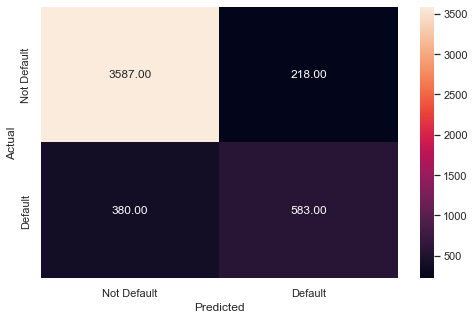

The performance on the test data
1192
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       966
           1       0.68      0.58      0.63       226

    accuracy                           0.87      1192
   macro avg       0.79      0.76      0.77      1192
weighted avg       0.86      0.87      0.86      1192



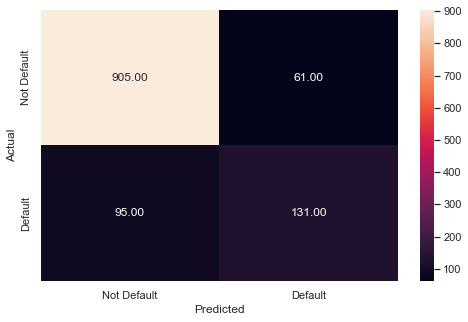

In [2338]:
# Logestic regression without parameters
lr = logestic_reg(X_train_transformed,y_train,X_test_transformed,y_test)

In [2339]:
lr_test = model_performance_classification(lr,X_test_transformed,y_test)
lr_test

,Precision,Recall,Accuracy,F1
0,0.793646,0.75825,0.869128,0.626794


The performance on the training data
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      3805
           1       0.60      0.76      0.67       963

    accuracy                           0.85      4768
   macro avg       0.77      0.82      0.79      4768
weighted avg       0.87      0.85      0.86      4768



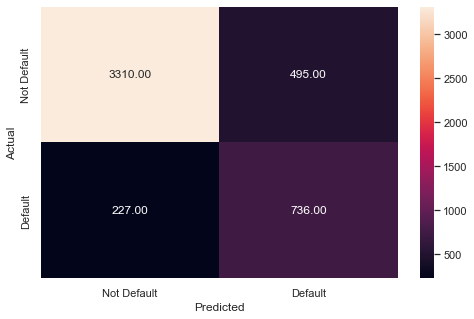

The performance on the test data
1192
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       966
           1       0.58      0.78      0.66       226

    accuracy                           0.85      1192
   macro avg       0.76      0.82      0.78      1192
weighted avg       0.87      0.85      0.86      1192



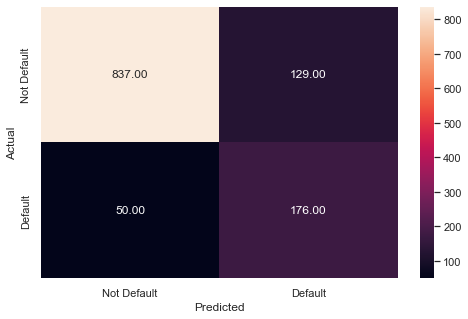

In [2340]:
lr_paramterized = logestic_reg(X_train_transformed,y_train,X_test_transformed,y_test,'balanced')

In [2341]:
lr_paramterized_test = model_performance_classification(lr_paramterized,X_test_transformed,y_test)
lr_paramterized_test

,Precision,Recall,Accuracy,F1
0,0.76034,0.82261,0.849832,0.6629


The recall is 7% better when the class_weight is set to 'balanced'

**Lets try nonlinear models, starting by decision tree**

### Decision Tree

In [2342]:
# Building decision tree model

def decision_tree(X_train,y_train,X_test,y_test):
    '''
    Builds a decision tree using the default values of the parameters
    Args:
    X_train: pd.DataFrame
    X_train: pd.DataFrame
    y_train: Pd.Series
    y_test: pd.Series
    
    return:
    dt: DecisionTreeClassifier 
    
    '''
    dt = DecisionTreeClassifier(random_state = 10)
        # Fitting decision tree model
    dt.fit(X_train, y_train)
    
    check_performance(dt,X_train,y_train,X_test,y_test)
    return dt

    

The performance on the training data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3805
           1       1.00      1.00      1.00       963

    accuracy                           1.00      4768
   macro avg       1.00      1.00      1.00      4768
weighted avg       1.00      1.00      1.00      4768



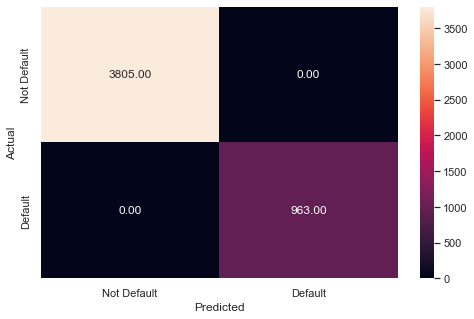

The performance on the test data
1192
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       966
           1       0.64      0.58      0.61       226

    accuracy                           0.86      1192
   macro avg       0.77      0.75      0.76      1192
weighted avg       0.86      0.86      0.86      1192



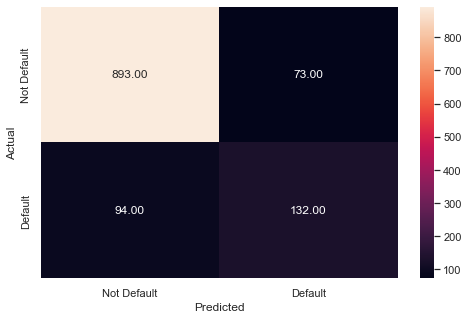

In [2343]:
dt = decision_tree(X_train_transformed,y_train,X_test_transformed,y_test)

In [2344]:
dt_test = model_performance_classification(dt,X_test_transformed,y_test)
dt_test

,Precision,Recall,Accuracy,F1
0,0.774332,0.754251,0.859899,0.612529


**Observations**
- The accuracy is 100% on the training dataset, which indicates an overfit.
- The recall is high on the test data but is biased towards the non-defaulters.

**Now, we will work to tune model parameters to enhance its performance.**

### **Decision Tree - Hyperparameter Tuning**

* Hyperparameter tuning is tricky in the sense that **there is no direct way to calculate how a change in the hyperparameter value will reduce the loss of your model**, so we usually resort to experimentation. We'll use Grid search to perform hyperparameter tuning.
* **Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters.** 
* **It is an exhaustive search** that is performed on the specific parameter values of a model.
* The parameters of the estimator/model used to apply these methods are **optimized by cross-validated grid-search** over a parameter grid.

**Criterion {“gini”, “entropy”}**

The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

**max_depth** 

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**min_samples_leaf**

The minimum number of samples is required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.



**In the next tuned decision tree, we will set weights for classes. More emphasis will be given to defaulters or class 1, with weight 0.8.**

In [2345]:
def decision_tree_tuning(X_train,y_train,X_test,y_test):
    '''
    
    Builds a tuned decision tree using grid search to find the best combination of the parameters 
    Args:
    X_train: pd.DataFrame
    X_train: pd.DataFrame
    y_train: Pd.Series
    y_test: pd.Series
    
    return:
    dt_estimator_tuned: DecisionTreeClassifier     
    
    '''
    
    dtree_estimator = DecisionTreeClassifier(class_weight = {0: 0.2, 1: 0.8}, random_state = 10)

    # Grid of parameters to choose from
    parameters = {'max_depth': np.arange(2, 10), 
                  'criterion': ['gini', 'entropy'],
                  'min_samples_leaf': np.arange(5,100,10),
                  'max_features':[0.5,0.7,0.9,'auto']
                     }

        # Type of scoring used to compare parameter combinations
    scorer = metrics.make_scorer(recall_score, pos_label = 1)

        # Run the grid search
    gridCV = GridSearchCV(dtree_estimator, parameters, scoring = scorer, cv = 10)

        # Fitting the grid search on the train data
    gridCV = gridCV.fit(X_train, y_train)

        # Set the classifier to the best combination of parameters
    dtree_estimator_tuned = gridCV.best_estimator_

        # Fit the best estimator to the data
    dtree_estimator_tuned.fit(X_train, y_train)
    check_performance(dtree_estimator_tuned,X_train_transformed,y_train,X_test_transformed,y_test)
    print('Best values after tunning ', gridCV.best_params_)
    return dtree_estimator_tuned




The performance on the training data
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      3805
           1       0.54      0.85      0.66       963

    accuracy                           0.82      4768
   macro avg       0.75      0.83      0.77      4768
weighted avg       0.87      0.82      0.84      4768



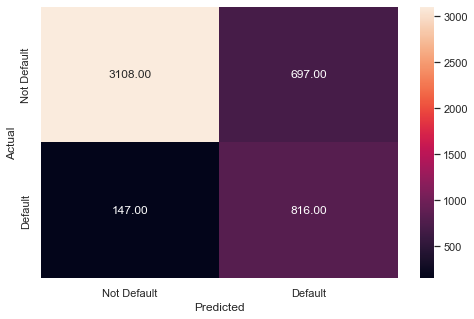

The performance on the test data
1192
              precision    recall  f1-score   support

           0       0.95      0.80      0.87       966
           1       0.48      0.82      0.61       226

    accuracy                           0.80      1192
   macro avg       0.72      0.81      0.74      1192
weighted avg       0.86      0.80      0.82      1192



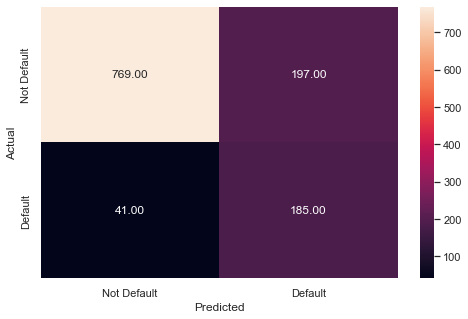

Best values after tunning  {'criterion': 'gini', 'max_depth': 9, 'max_features': 0.5, 'min_samples_leaf': 45}


In [2346]:
dt_tuned = decision_tree_tuning(X_train_transformed,y_train,X_test_transformed,y_test)


In [2347]:
dt_tuned_test = model_performance_classification(dt_tuned,X_test_transformed,y_test)
dt_tuned_test

,Precision,Recall,Accuracy,F1
0,0.716838,0.807325,0.800336,0.608553


**Observations**

- The performance are enhanced after tuning on both training and testing data.
- The best values of the parameters found using gridsearch are **{'criterion': 'entropy', 'max_depth': 9, 'max_features': 0.7, 'min_samples_leaf': 75}**.
- The decision gives good results, however we can try more complicated algorithms to enhance F1.



In [2348]:
def plot_feat_importance(model,X_train):
    '''
    Plot the importance of the features based on the given model
    Args:
    model: classification model
    X_train: pd.DataFrame
    
    '''

    importances = model.feature_importances_

    columns = X_train.columns

    importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

    plt.figure(figsize = (13, 13))

    sns.barplot(x=importance_df.Importance,y=importance_df.index)

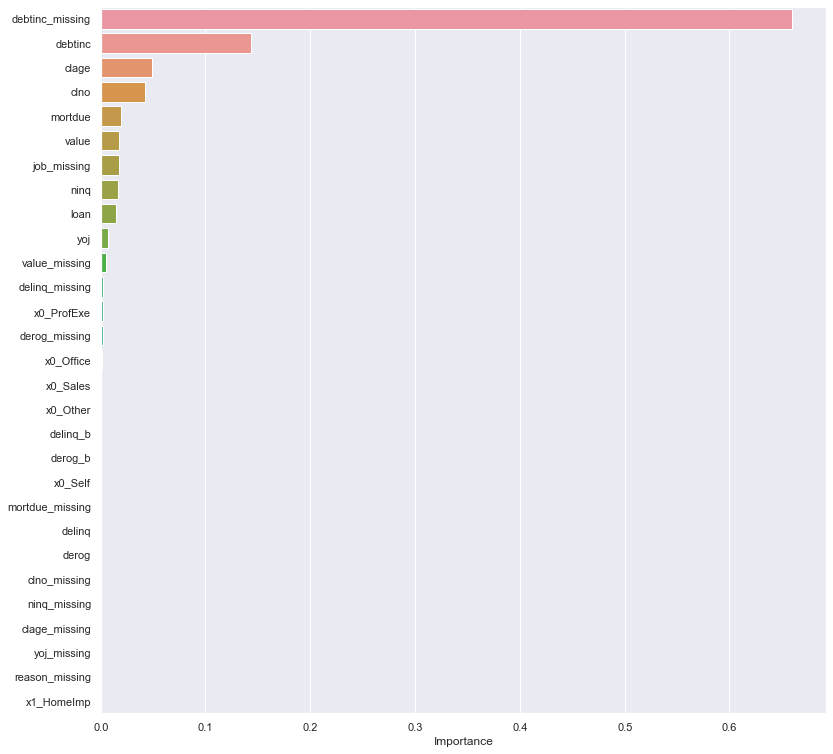

In [2349]:
plot_feat_importance(dt_tuned,X_train_transformed)

**Next we plot the decision tree**

In [2350]:
def plot_tree(dt,X_train):
    features = list(X_train.columns)

    plt.figure(figsize = (30, 20))

    tree.plot_tree(dt, max_depth = 4, feature_names = features, filled = True, fontsize = 12, node_ids = True, class_names = True)

    plt.show()

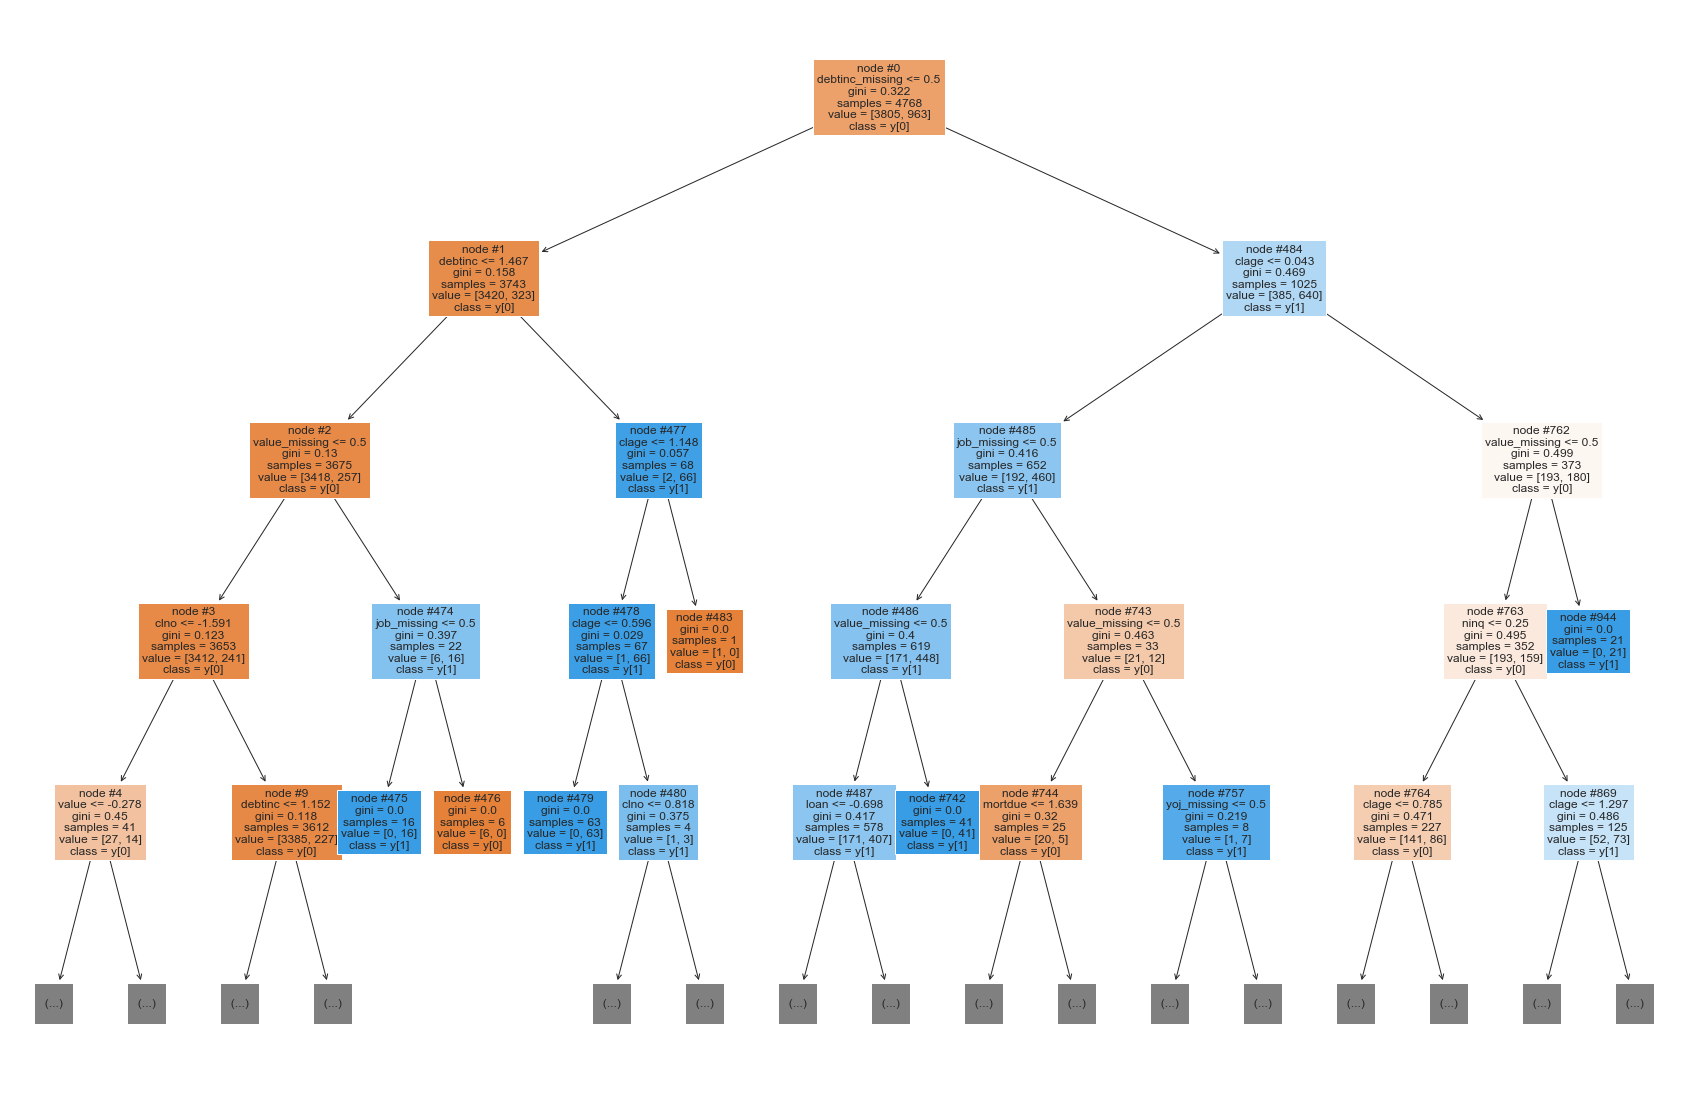

In [2351]:
plot_tree(dt,X_train_transformed)

In [2352]:
dt_tuned_test = model_performance_classification(dt_tuned,X_test_transformed,y_test)
dt_tuned_test

,Precision,Recall,Accuracy,F1
0,0.716838,0.807325,0.800336,0.608553


#### **Observations**
- Debt-to-income feature differentiates defaulters and non-defaulters.
- Features age of oldest credit line *clage*, number of existing credit lines *clno*, amount of due mortgage *mortdue* come after debt-to-inc.
- If the missing values in feature **debtinc** less or equal to 50%, then customers are more likely to default.
- With **debtinc** < = 1.47, customers default.
- the performance is enhanced in the tune decision tree model.

### **Building a Random Forest Classifier**

Random Forest is a bagging algorithm where the base models are Decision trees. Samples are taken from the training data and on each sample a decision tree makes a prediction. 
The results from all the decision trees are combined together and the final prediction is made using voting or averaging.

In [2353]:
def random_forest(X_train,y_train,X_test,y_test):
    rf_estimator = RandomForestClassifier(class_weight = {0: 0.2, 1: 0.8}, random_state = 10)
    rf_estimator.fit(X_train, y_train)
    check_performance(rf_estimator,X_train,y_train,X_test,y_test)
    return  rf_estimator 

    
    

The performance on the training data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3805
           1       1.00      1.00      1.00       963

    accuracy                           1.00      4768
   macro avg       1.00      1.00      1.00      4768
weighted avg       1.00      1.00      1.00      4768



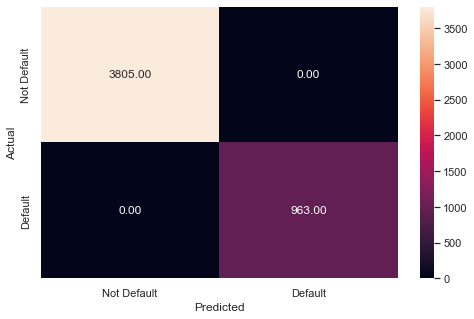

The performance on the test data
1192
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       966
           1       0.76      0.62      0.69       226

    accuracy                           0.89      1192
   macro avg       0.84      0.79      0.81      1192
weighted avg       0.89      0.89      0.89      1192



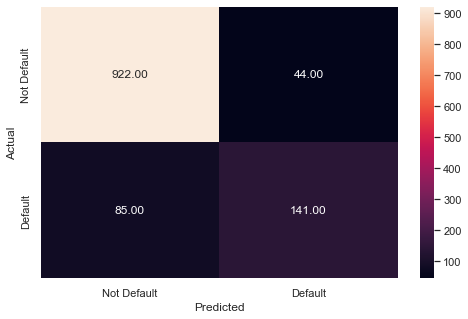

In [2355]:
rf = random_forest(X_train_transformed,y_train,X_test_transformed,y_test)

In [2356]:
rf_test = model_performance_classification(rf,X_test_transformed,y_test)
rf_test

,Precision,Recall,Accuracy,F1
0,0.838877,0.789173,0.891779,0.686131


**Observations**
- The accuracy of the training is 100% and 89% on the test data, and that is a sign of overfitting.
- Tuning the model can be useful to overcome the overfitting problem.

### **Random Forest Classifier Hyperparameter Tuning**

**n_estimators**: The number of trees in the forest.

**min_samples_split**: The minimum number of samples required to split an internal node.

**min_samples_leaf**: The minimum number of samples required to be at a leaf node. 

**max_features{“auto”, “sqrt”, “log2”, 'None'}**: The number of features to consider when looking for the best split.

- If “auto”, then max_features=sqrt(n_features).

- If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).

- If “log2”, then max_features=log2(n_features).

- If None, then max_features=n_features.

In [2405]:
def random_forest_tuning(X_train,y_train,X_test,y_test):
    '''
    Builds a tuned random forest using grid search to find the best combination of parameters values
    Args:
    X_train: pd.DataFrame
    X_train: pd.DataFrame
    y_train: Pd.Series
    y_test: pd.Series
    
    return:
    rf_estimator_tuned: RandonForstClassifier 
    best_params: Dict
    
    
    '''

    rf_estimator_tuned = RandomForestClassifier(class_weight = {0: 0.2, 1: 0.8}, random_state = 10)
    # Grid of parameters to choose from
    params_rf = {  
        "n_estimators": [100, 200,300],
        "min_samples_leaf": np.arange(1, 4, 1),
        "max_features": [0.7, 0.9, 'auto','log2'],
        "criterion":['gini','entropy'],
        "min_samples_split": np.arange(1,4,1)
        }

    # Type of scoring used to compare parameter combinations - recall score for class 1
    scorer = metrics.make_scorer(recall_score, pos_label = 1)

    # Run the grid search
    grid_obj = GridSearchCV(rf_estimator_tuned, params_rf, scoring = scorer, cv = 5)
    grid_obj = grid_obj.fit(X_train, y_train)

    # Set the classifier to the best combination of parameters
    rf_estimator_tuned = grid_obj.best_estimator_
    rf_estimator_tuned.fit(X_train, y_train)

    check_performance(rf_estimator_tuned,X_train,y_train,X_test,y_test)
    best_params = grid_obj.best_params_
    print('Best values after tunning ', grid_obj.best_params_)
    return rf_estimator_tuned, best_params


The performance on the training data
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      3805
           1       0.78      0.96      0.86       963

    accuracy                           0.94      4768
   macro avg       0.88      0.95      0.91      4768
weighted avg       0.95      0.94      0.94      4768



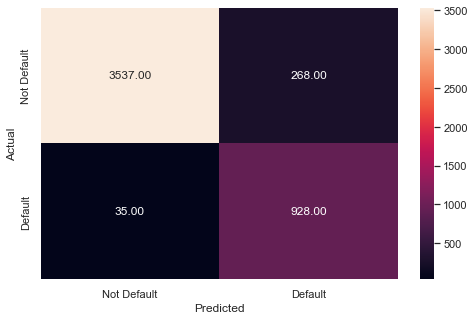

The performance on the test data
1192
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       966
           1       0.67      0.80      0.73       226

    accuracy                           0.89      1192
   macro avg       0.81      0.85      0.83      1192
weighted avg       0.90      0.89      0.89      1192



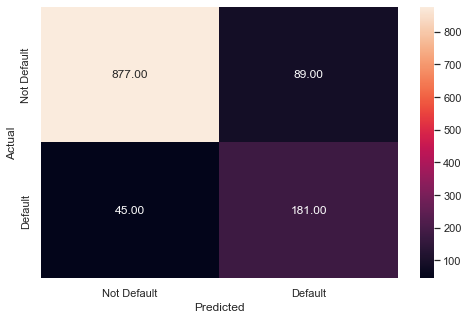

Best values after tunning  {'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}


In [2392]:
rf_tuned,best_params_rf = random_forest_tuning(X_train_transformed,y_train,X_test_transformed,y_test)

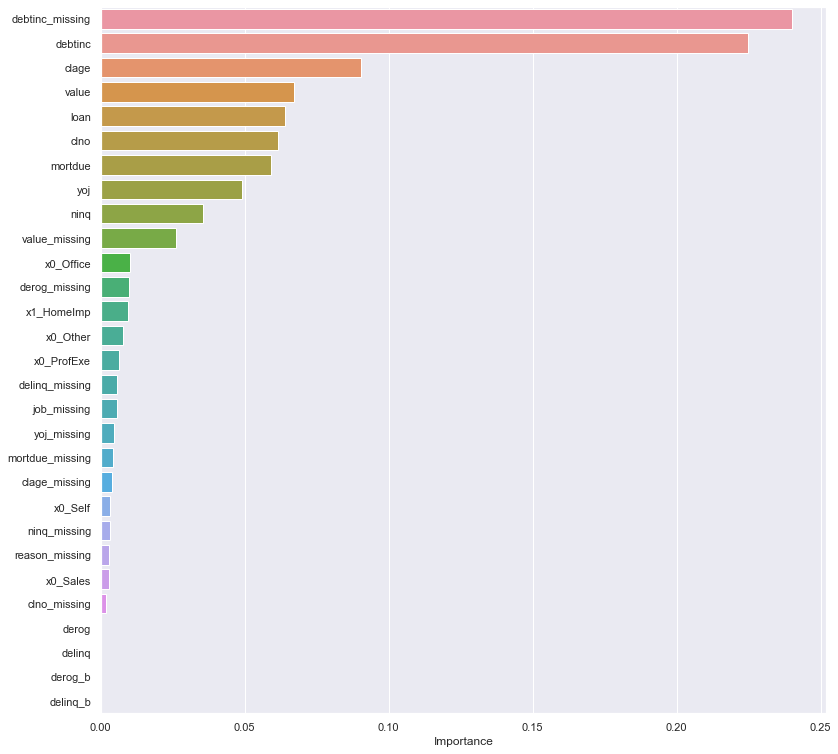

In [2393]:
plot_feat_importance(rf_tuned,X_train_transformed)

In [2394]:
rf_tuned_test = model_performance_classification(rf_tuned, X_test_transformed, y_test)
rf_tuned_test

,Precision,Recall,Accuracy,F1
0,0.810782,0.854376,0.887584,0.729839


**Observations**

- Tuning the parameters overcome the overfitting issue.
- The tuned random forest model could better find the patterns in the data and recall score increases.
- The most important features are bebtinc_missing, debtinc, clang,value.
- The best values for the parameters are {'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}


### Random Forest Classifier and SMOTE

Due to the imbalanced nature of the data, the performance of the model may exhibit bias towards one class while neglecting others. To address this issue, an effective approach is to enhance the random forest model by employing the Synthetic Minority Oversampling Technique (SMOTE). SMOTE involves generating synthetic observations to overcome data imbalance, thereby improving the representation of minority classes and addressing potential bias in model predictions.

In [2404]:
oversample = SMOTE(random_state=10)
X_train_transformed_sample, y_train_sample = oversample.fit_resample(X_train_transformed, y_train)

The performance on the training data
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      3805
           1       0.92      1.00      0.96      3805

    accuracy                           0.95      7610
   macro avg       0.96      0.95      0.95      7610
weighted avg       0.96      0.95      0.95      7610



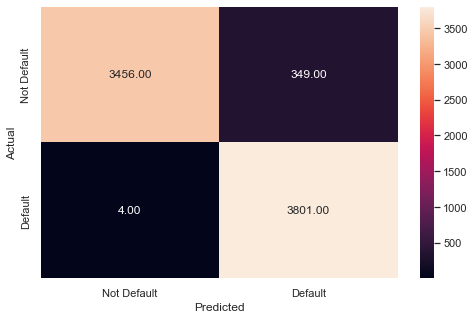

The performance on the test data
1192
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       966
           1       0.66      0.86      0.75       226

    accuracy                           0.89      1192
   macro avg       0.81      0.88      0.84      1192
weighted avg       0.91      0.89      0.89      1192



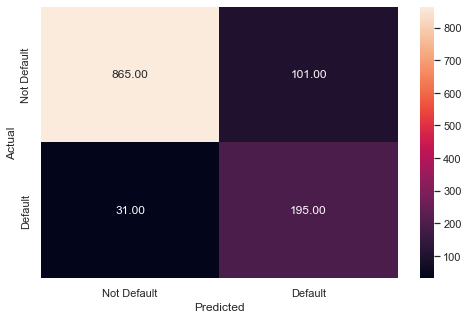

In [2398]:
rf_tuned_smote = RandomForestClassifier(class_weight = {0: 0.2, 1: 0.8},
                                        max_features=best_params_rf['max_features'],
                                        min_samples_leaf=best_params_rf['min_samples_leaf'],
                                        min_samples_split=best_params_rf['min_samples_split'],
                                        n_estimators=best_params_rf['n_estimators'],
                                        criterion =best_params_rf['criterion'],
                                        
                                        random_state = 10)
rf_tuned_smote.fit(X_train_transformed_sample, y_train_sample)
check_performance(rf_tuned_smote,X_train_transformed_sample,y_train_sample,X_test_transformed,y_test)

    
    

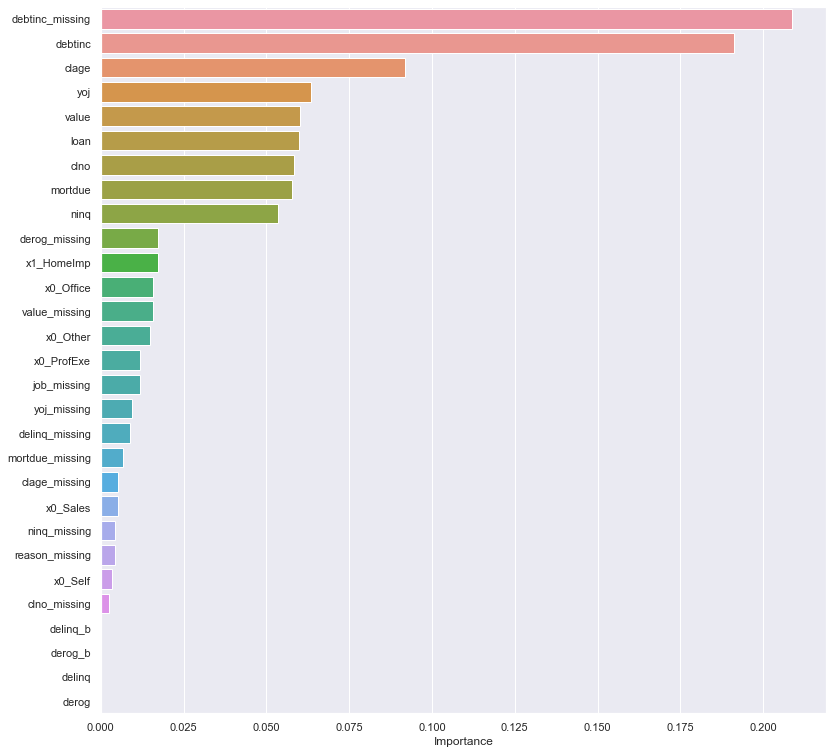

In [2399]:
plot_feat_importance(rf_tuned_smote,X_train_transformed)

In [2413]:
rf_tuned_smote_test = model_performance_classification(rf_tuned_smote, X_test_transformed, y_test)
rf_tuned_smote_test

,Precision,Recall,Accuracy,F1
0,0.812093,0.879138,0.889262,0.747126


**Using SMOTE enhances the performance of the tuned random forest model.**

**Observations**
- Resampling using SMOTE increases all performance metrecies.
- Recall gets higher by 2% when SMOTE is used.
- The most important features are slightly different than the previous model, which are debtinc_missing, debtinc, clage, yoj.

### Models Evaluation 

**Comparison of various techniques and their relative performance based on chosen Metric (Measure of success):** 

The following table shows the performance using 7 models choices:
- Logestic Regression
- Logestic Regression Parameterized
- Decision Tree classifier
- Tuned Decision Tree classifier
- Random Forest classifier
- Tuned Random Forest classifier
- Tuned Random Forest classifier and SMOTE
    
Models are evaluated using four scoring metrecies: 
- Precision
- Recall
- Accuracy
- F1

The best model is chosen mainly based on higher recall and F1 score. As mentioned earlier, Banks care more about reducing the errors that cause predicting customers as non-defaulters but they are not. 



In [2403]:
# Compare all models
models_test_comp_df = pd.concat(
    
    [    
    lr_test.T,lr_paramterized_test.T,dt_test.T,dt_tuned_test.T,rf_test.T,rf_tuned_test.T, rf_tuned_smote_test.T
    ],
    
    axis = 1,
)

models_test_comp_df.columns = [
    "Logestic Regression",
    "Logestic Regression Parameterized",
    "Decision Tree classifier",
    "Tuned Decision Tree classifier",
    "Random Forest classifier",
    "Tuned Random Forest classifier",
    "Tuned Random Forest classifier and SMOTE" 
]

print("Test performance comparison:")

Test performance comparison:


In [2401]:
models_test_comp_df

,Logestic Regression,Logestic Regression Parameterized,Decision Tree classifier,Tuned Decision Tree classifier,Random Forest classifier,Tuned Random Forest classifier,Tuned Random Forest classifier and SMOTE
Precision,0.793646,0.760340,0.774332,0.716838,0.838877,0.810782,0.812093
Recall,0.758250,0.822610,0.754251,0.807325,0.789173,0.854376,0.879138
Accuracy,0.869128,0.849832,0.859899,0.800336,0.891779,0.887584,0.889262
F1,0.626794,0.662900,0.612529,0.608553,0.686131,0.729839,0.747126


### Business Summary

#### Executive Summary
We pointed earlier to two main questions:
- Which clients are more likely to default on their loan?
- What are the essential createria to consider during the load approval process?

The goal is to develop a classification model that can accurately predict which customers are at risk of defaulting on their loans. Through detailed data analysis, the aim is to draw meaningful conclusions and provide recommendations to banks regarding key criteria to inform future decision-making processes.

**Here are the main findings**:

- The dataset comprises 5,960 unique observations, each with 12 predictor variables, largely numerical, which makes analysis convenient.
- There are no duplicated entries in the dataset.
- Approximately 7% of the data contains missing values.
- The data shows the presence of several outliers, with most features exhibiting right-skewness.
- Due to the skewness and outliers, additional efforts are needed during the analysis and data preparation stages.
- Among the tested models, debt-to-income ratio emerges as the most significant feature, indicating customers' repayment capabilities, with lower values being preferable.
- Customers with a high number of derogatory reports and delinquent credit lines are more likely to default.
- Further analysis reveals that customers in sales roles are the most prone to default, followed by self-employed.
- The mean of requested loan is around 18608 and at least 50% of the customers request loan reaches 16300\$.
- The year of current job feature is right skewed and at least 50\% of the requested loan amounts are higher than 7,000,000\$.
- In the provided dataset, customers primarily request loans for either Home Improvement or Debt Consolidation. However, the occurrence of Home Improvement requests is more frequent compared to Debt Consolidation.
- There are six distinct job categories for loan applicants.
- There is a strong positive correlation between mortgage amount and loan value.
- There are six unique job titles in the data, and *Other* is the most common job.
- The means of loan, mortdue, and value are lower for defaulters compared to non-defaulters.
- The amount of loan increases if the value of the property is high.
- Customers with a high number of derogatory reports and delinquent credit lines tend to request lower loan amounts.


**The proposed model**

The optimal model in the present study should prioritize interpretability to effectively identify the key independent features for accurate predictions. Additionally, the ultimate model must minimize errors, particularly in misclassifying defaulter cases as non-defaulter cases.

Among the various models evaluated, the Random Forest model with tuned hyperparameters and SMOTE technique demonstrated superior performance. It achieved impressive metrics including a Recall of 0.88, F1 score of 0.75, Precision of 0.81, and accuracy of 0.90. Notably, the most influential features identified in this model are missing values indicated by debtinc_missing, debt-to- income (debtinc), age of the oldest credit lines (clage), and year in the current job (yoj).

Once real-world data testing is completed, this model is ready for deployment in a production environment. As model development is an ongoing process, it can be deployed and monitored continuously. During the monitoring phase, data scientists should maintain regular communication with stakeholders to ensure that the model is operating as intended.


#### Problem and Solution Summary

The consumer credit department at the bank is actively working towards simplifying and improving the approval process for home equity lines of credit, with the ultimate goal of enhancing its efficiency and effectiveness. One potential solution being explored is the development of a credit scoring model that adheres to the guidelines of the Equal Credit Opportunity Act. This model would be designed to accurately differentiate between defaulters and non-defaulters, utilizing data from existing loans that have been extended credit. It is crucial that the model's predictions align with real-world scenarios, but equally important is the requirement for the model to be explainable, allowing for transparency and understanding of the decision-making process.
By automating manual work that can be prone to errors and biases, the implementation of such a credit scoring model has the potential to mitigate risks and prevent significant financial losses for the bank. With advancements in machine learning algorithms and the availability of robust infrastructure, the designed model can significantly enhance the accuracy and efficiency of the credit approval process, safeguarding the bank's financial interests.

#### Recommendations for Implementation

**Recommendation**
- A significant portion of resources should be allocated to analyzing and preprocessing the data, as many variables exhibit right-skewed distributions and a notable presence of outliers.
- Customers with a high debt-to-income ratio pose a higher risk of defaulting on their debts, as consistently observed across multiple tested models. However, it is worth noting that this feature also has a considerable percentage of missing values in the dataset. 
- Stakeholders are advised to explore alternative approaches to address and impute the missing values.
- The analysis reveals that customers with longer tenures in their current jobs are more likely to repay their loans, indicating the importance of focusing on this group.
- Stakeholders should also take into account that customers with longer credit histories and older credit lines tend to have higher loan repayment rates, emphasizing the need to consider these factors in decision-making processes.
- The proposed model can be deployed and further testing is required with new data.


**Risks and Challenges**

- The implementation of the new model in a real-world setting comes with inherent risks of making mistakes, and as such, it requires diligent monitoring and continuous improvement for both predictivity and interpretability.

    - Adequate time and resources should be allocated for ongoing monitoring and enhancement of the model during its production phase.
    - Additionally, further training may be necessary for employees in the consumer credit department to effectively work with and utilize the newly adopted model, ensuring their proficiency in its operation and interpretation.


**Further Analysis**
- Evaluating the model on new data is a crucial step to mitigate potential data drift issues.
    - Exploring alternative ensemble algorithms, such as boosting, may lead to improved performance, but it requires careful tuning of a large set of parameters, which may necessitate additional time and resources.
    - It is imperative to prioritize interpretability when proposing any model to ensure its transparency and comprehensibility in decision-making processes.